## Word-level Sequential Model for Sentiment Classification

TOTAL POINTS FOR THIS CODING ASSIGNMENT: 9 POINTS

In [1]:
from __future__ import print_function

### 1. Data set

We will use IMDB review data set for generating the encoding of sentence (i.e text review from user) to classify sentiment polarity of this text. Data is originally taken from https://www.kaggle.com/c/word2vec-nlp-tutorial/data. It contains 25000 reviews with labels 0 for "negative" sentiment and 1 for "positive" sentiment. For validation set, the information about binary labels (0 and 1) can be seen in attribute "id" of the data set. Number after character '\_' represents rating score. If rating <5, then the sentiment score is 0 or "negative" sentiment. If the rating >=7, then the score is 1 or "positive. Otherwise, is negative. For test set, data is provided without label.

Example of (part of) original text in data set:

```
id	sentiment	review

"7759_3"	0	"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger ."

```

### 2. Problem Definition

Given a text (e.g. a movie review), we will predict whether this review is positive (class label=1) or negative (class label =0).

### 3. Tasks:

* Encode text using LSTM as an encoder layer.
* Project the output of encoder model to dense prediction layer.
* Train the model with objective function to minimize error loss of sentiment classification task, given the encoding of text sequence as the input of the model.

YOUR ASSIGNMENT TASKS:
* <span style="color:red">Plot error loss and accuracy in training and validation stage. Discuss the result.</span>
* <span style="color:red">Generate document embedding from RNN layer that has been trained and optimized to the sentiment classification task.</span>
* <span style="color:red">Visualize the resulting document embedding and project to their sentiment labels in embedding space.</span>
* <span style="color:red">Test with new set of document (raw data set is provided).</span>
* <span style="color:red">Assign new labels to new unseen and unlabelled document. You will need to encode this raw document as well as a query to source (trained) document embedding. Sample only 10 new unlabelled documents.</span>

### 4. Read preprocessed data

In [2]:
import os
import sys
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
import re
import nltk
import string
from string import punctuation

DATA_PATH = 'data/imdb'
MODEL_PATH = 'model/assignment_3_1'

In [3]:
import _pickle as cPickle

# reading file in pickle format
def readPickle(pickleFilename):
    f = open(pickleFilename, 'rb')
    obj = cPickle.load(f)
    f.close()
    return obj

In [4]:
def savePickle(dataToWrite,pickleFilename):
    f = open(pickleFilename, 'wb')
    cPickle.dump(dataToWrite, f)
    f.close()

In [5]:
def striphtml(html):
    p = re.compile(r'<.*?>')
    return p.sub('', html)

In [6]:
def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)

In [7]:
data = pd.read_csv(os.path.join(DATA_PATH,"labeledTrainData.tsv"), header=0, delimiter="\t", quoting=3)

In [8]:
valid_data = pd.read_csv(os.path.join(DATA_PATH,"testData.tsv"), header=0, delimiter="\t")

In [ ]:
txt = ''
docs = []
sentiments = []
for cont, sentiment in zip(data.review, data.sentiment):
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    docs.append(doc)
    sentiments.append(sentiment)

In [ ]:
valid_docs =[]
valid_labels = []
i=0
for docid,cont in zip(valid_data.id, valid_data.review):
    id_label = docid.split('_')
    if(int(id_label[1]) >= 7):
        valid_labels.append(1)
    else:
        valid_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    valid_docs.append(doc)

In [ ]:
def tokenizeWords(text):
    tokens = re.sub(r"[^a-z0-9]+", " ", text.lower()).split()
    return [str(strtokens) for strtokens in tokens]

In [ ]:
def indexingVocabulary(array_of_words):

    wordIndex = list(array_of_words)
    wordIndex.insert(0,'</PAD>')
    if 'sof' not in array_of_words:
        wordIndex.append('</START_DOC>')
    if 'eof' not in array_of_words:
        wordIndex.append('</END_DOC>')
    wordIndex.append('</UNK>')
    vocab=dict([(i,wordIndex[i]) for i in range(len(wordIndex))])
    return vocab

In [ ]:
train_str_tokens = []
all_tokens = []
for i, text in enumerate(docs):
    # tokenize text 
    train_str_tokens.append(tokenizeWords(text))
    all_tokens.extend(tokenizeWords(text))

In [ ]:
print(train_str_tokens[0][:10])

In [ ]:
valid_str_tokens = []
for i, text in enumerate(valid_docs):
    # tokenize text 
    valid_str_tokens.append(tokenizeWords(text))

In [ ]:
tf = nltk.FreqDist(all_tokens)
common_words = tf.most_common(5000)
arr_common = np.array(common_words)
words = arr_common[:,0]

In [ ]:
words_indices = indexingVocabulary(words)
indices_words = dict((v,k) for (k,v) in words_indices.items())

In [ ]:
list(words_indices.items())[:5]

In [ ]:
list(indices_words.items())[:5]

In [ ]:
# integer format of training input 
train_int_input = []
for i, text in enumerate(train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['</UNK>'] for w in text ]
    train_int_input.append(int_tokens)

In [ ]:
# integer format of test validation input 
valid_int_input = []
for i, text in enumerate(valid_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['</UNK>'] for w in text ]
    valid_int_input.append(int_tokens)

In [ ]:
X_train = np.array(train_int_input)
y_train = np.array(sentiments)

In [ ]:
X_valid = np.array(valid_int_input)
y_valid = np.array(valid_labels)

In [ ]:
# storing training and validation set
savePickle(X_train, os.path.join(DATA_PATH,'X_train'))
savePickle(y_train, os.path.join(DATA_PATH,'y_train'))
savePickle(X_valid, os.path.join(DATA_PATH,'X_valid'))
savePickle(y_valid, os.path.join(DATA_PATH,'y_valid'))
# storing look-up dictionary for vocabulary index
savePickle(words_indices, os.path.join(DATA_PATH,'words_indices'))
savePickle(indices_words, os.path.join(DATA_PATH,'indices_words'))

In [ ]:
# YOUR CODE HERE TO PREPARE THE ENCODING OF NEW UNSEEN UNLABELED TEST DATA 
# (1 POINT)

# 1. Read file data/unlabeledTrainData.csv (ONLY USE FIRST 1000 DOCUMENTS)
# 2. Do similar preprocessing as in training and validation set
# 3. Encode to integer format of sequences

############################
# (My version)

# 1. reading data

X_train = readPickle(os.path.join(DATA_PATH,'X_train'))
y_train = readPickle(os.path.join(DATA_PATH,'y_train'))
X_valid = readPickle(os.path.join(DATA_PATH,'X_valid'))
y_valid = readPickle(os.path.join(DATA_PATH,'y_valid'))
words_indices = readPickle(os.path.join(DATA_PATH,'words_indices'))
indices_words = readPickle(os.path.join(DATA_PATH,'indices_words'))

#test_data = pd.read_csv(os.path.join(DATA_PATH,"unlabeledTrainData.tsv"), header=0, delimiter="\t", \
#                        error_bad_lines=False, nrows=25000)

test_data = pd.read_csv(os.path.join(DATA_PATH,"unlabeledTrainData.tsv"), header=0, delimiter="\t", \
                        error_bad_lines=False)

# 2. Preprocess and label data
# - clean from html entities and transform to lowercase text
# - provide labels
# - tokenize documents into tokens of words

test_docs =[]
i=0
for docid,cont in zip(test_data.id, test_data.review):
           
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    test_docs.append(doc)
    
test_str_tokens = []
for i, text in enumerate(test_docs):
    # tokenize text 
    test_str_tokens.append(tokenizeWords(text))
    
# 3. Encode to integer format of sequences

test_int_input = []
for i, text in enumerate(test_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['</UNK>'] for w in text ]
    test_int_input.append(int_tokens)
    
X_test = np.array(test_int_input)


In [ ]:
savePickle(X_test, os.path.join(DATA_PATH,'X_test'))


In [13]:
X_train = readPickle(os.path.join(DATA_PATH,'X_train'))
y_train = readPickle(os.path.join(DATA_PATH,'y_train'))
X_valid = readPickle(os.path.join(DATA_PATH,'X_valid'))
y_valid = readPickle(os.path.join(DATA_PATH,'y_valid'))
words_indices = readPickle(os.path.join(DATA_PATH,'words_indices'))
indices_words = readPickle(os.path.join(DATA_PATH,'indices_words'))

In [9]:
X_test = readPickle(os.path.join(DATA_PATH,'X_test'))

In [10]:
X_test.shape

(49998,)

### 5. Word-level document encoder

In [11]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [14]:
max_review_length = 500
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_valid_pad = sequence.pad_sequences(X_valid, maxlen=max_review_length)

In [28]:
from keras.models import Model
from keras.layers import Dense, Input, Embedding
from keras.layers import LSTM

latent_dim = 100  # Latent dimensionality of the encoding space.
embedding_dim = 32

encoder_input = Input(shape=(None,), name='encoder_inputs')
encoder_embedding = Embedding(len(words_indices), embedding_dim, name='embedding_encoder')(encoder_input)
lstm_encoder = LSTM(latent_dim, name='lstm_encoder')(encoder_embedding)
output_encoder = Dense(1, activation='sigmoid')(lstm_encoder)
model = Model(inputs=encoder_input, outputs=output_encoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, None)              0         
_________________________________________________________________
embedding_encoder (Embedding (None, None, 32)          160128    
_________________________________________________________________
lstm_encoder (LSTM)          (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,429
Trainable params: 213,429
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [ ]:
model.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid), epochs=3, batch_size=64)

In [30]:
# YOUR CODE HERE
# (1 POINT)

# CHANGE BELOW CODE FOR TRAINING THE MODEL
# 1. Increase epoch number for inspecting the error loss through epochs 
#    (optional - if your computation resource is sufficient)
# 2. Add callback function for historical error loss and accuracy during training and validation stage
# 3. Plot history of error loss and accuracy (with matplotlib or any available library)


# (My version)
# 1. Skipped

# 2. Callback function

import keras.callbacks

# record history of training
class LossHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.ep_loss = []
        self.ep_accuracy = []
        self.ep_val_loss = []
        self.ep_val_accuracy = []
        self.batch_loss = []
        self.batch_accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
        self.batch_accuracy.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.ep_loss.append(logs.get('loss'))
        self.ep_accuracy.append(logs.get('acc'))
        self.ep_val_loss.append(logs.get('val_loss'))
        self.ep_val_accuracy.append(logs.get('val_acc'))
        
history = LossHistory()
        
model.fit(X_train_pad[:5000], y_train[:5000], validation_data=(X_valid_pad[:5000], y_valid[:5000]), epochs=3, batch_size=64, callbacks=[history])



Train on 5000 samples, validate on 5000 samples
Epoch 1/3
5000/5000 [==============================] - 164s 33ms/step - loss: 0.6798 - acc: 0.6048 - val_loss: 0.6919 - val_acc: 0.5562
Epoch 2/3
5000/5000 [==============================] - 160s 32ms/step - loss: 0.4859 - acc: 0.7958 - val_loss: 0.4961 - val_acc: 0.7816
Epoch 3/3
5000/5000 [==============================] - 150s 30ms/step - loss: 0.3410 - acc: 0.8656 - val_loss: 0.4382 - val_acc: 0.8156


In [ ]:
arr_ep_loss = np.array(history.ep_loss)
arr_ep_acc = np.array(history.ep_accuracy)
arr_ep_val_loss = np.array(history.ep_val_loss)
arr_ep_val_acc = np.array(history.ep_val_accuracy)

arr_batch_loss = np.array(history.batch_loss)
arr_batch_accuracy = np.array(history.batch_accuracy)


In [ ]:
# Save training history

savePickle(arr_ep_loss, os.path.join(MODEL_PATH,'arr_ep_loss'))
savePickle(arr_ep_acc, os.path.join(MODEL_PATH,'arr_ep_acc'))
savePickle(arr_ep_val_loss, os.path.join(MODEL_PATH,'arr_ep_val_loss'))
savePickle(arr_ep_val_acc, os.path.join(MODEL_PATH,'arr_ep_val_acc'))

In [24]:
# 3. Plot error loss and accuracy 

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
x = np.arange(len(arr_ep_loss))

plt.clf()

plt.plot(arr_ep_loss, color='g', label='training loss')
plt.plot(arr_ep_val_loss, color='b', label='validation loss')
plt.xticks(x, x+1)
plt.xlabel('epoch')
plt.ylabel('error loss')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.savefig('error_loss.png')

![Image](./imgs/error_loss.png)

In [ ]:
plt.clf()

x = np.arange(len(arr_ep_acc))

plt.plot(arr_ep_acc, color='g', label='training accuracy')
plt.plot(arr_ep_val_acc, color='b', label='validation accuracy')
plt.xticks(x, x+1)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'], loc='center right')
plt.savefig('accuracy.png')

![Image](./imgs/accuracy.png)

### 6. Save the trained models and weights

In [ ]:
# Save model
model.save(os.path.join(MODEL_PATH,'word_sequence_classification_with_history_model.h5'))

In [ ]:
# Save trained weight parameters
model.save_weights(os.path.join(MODEL_PATH, 'weights_word_sequence_classification_with_history.hdf5'))

### 7. Retrieve the encoding of document that has been optimized to sentiment classification task

In [19]:
# YOUR CODE HERE
# (3 POINTS)

# 1. Generate document embedding from trained model and parameters. 
#    There are several ways to retrieve document embedding from LSTM encoder layer
# 2. Visualize w.r.t. sentiment labels (Use tSNE for dimensionality reduction)

# You may need to store your encoder model, full model, and weights for the next task (TASK 8)


# (my version)

# 1. generate document embedding

# a. loading from stored model and weight parameters and predict the document embedding from input sequences
#    create new model based on stored model and parameter
#    you can also use the trained model directly if you still have your notebook running

from keras.models import load_model
lstm_model = load_model(os.path.join(MODEL_PATH,'word_sequence_classification_with_history_model.h5'))
lstm_model.load_weights(os.path.join(MODEL_PATH,'weights_word_sequence_classification_with_history.hdf5'))

lstm_encoder_model_1 = Model(inputs=lstm_model.input, outputs=lstm_model.get_layer('lstm_encoder').output)
doc_embedding_1 = lstm_encoder_model_1.predict(X_valid_pad[:10000])


In [20]:
doc_embedding_1_10000 = doc_embedding_1

In [ ]:
lstm_encoder_model_1.save(os.path.join(MODEL_PATH,'encodermodel_1.h5'))

In [21]:
savePickle(doc_embedding_1_10000, os.path.join(EMBEDDING_PATH,'doc_embedding_1_10000'))

In [ ]:
# b. create new encoder model from the trained model -  while notebook is still running
# on 5000 validation documents

lstm_encoder_model_2 = Model(encoder_input, lstm_encoder)
doc_embedding_2_10000 = lstm_encoder_model_2.predict(X_valid_pad[:10000])

In [ ]:
lstm_encoder_model_2.save(os.path.join(MODEL_PATH,'encodermodel_2_10000.h5'))

In [ ]:
savePickle(doc_embedding_2_10000, os.path.join(EMBEDDING_PATH,'doc_embedding_2_10000'))

In [22]:
# 2. visualization

import matplotlib.cm as cm
from sklearn.manifold import TSNE

def reduceDimensionTSNE(n_dim, init_embedding, doc_vector):

    tsne = TSNE(n_components=n_dim, init =init_embedding)
    reduced_doc_vectors = tsne.fit_transform(doc_vector)

    return reduced_doc_vectors

# 1. Reduce dimension to 2

doc_embedding_1 = doc_embedding_1_10000[:5000]
tsne_2dim = reduceDimensionTSNE(2,'random', doc_embedding_1)
savePickle(tsne_2dim, os.path.join(EMBEDDING_PATH,'docvec_tsne_2dim_5000'))

In [184]:
x = (np.array(tsne_2dim))[:,0]
y = (np.array(tsne_2dim))[:,1]
labels = y_valid[:5000]
labeled_docvec = list(zip(labels,x,y))

df_labelled_docvec = pd.DataFrame(labeled_docvec, columns=['sentiment_labels', 'vector_0', 'vector_1'])
sorted_df = df_labelled_docvec.sort_values(['sentiment_labels'], ascending=True)
sorted_df = sorted_df.reset_index(drop=True)

class_labels = sorted_df.sentiment_labels.unique()
nlabels = len(class_labels)
colors = class_labels

plt.clf()
plt.rcParams["figure.figsize"] = (9,8)
class_colors = []
for i in range(nlabels):
    class_label = class_labels[i]
    color = colors[i]
    v0 = sorted_df[sorted_df['sentiment_labels'] == class_label]['vector_0']
    v1 = sorted_df[sorted_df['sentiment_labels'] == class_label]['vector_1']    
    plt.scatter(v0, v1, label=color, alpha=0.3)
    class_colors.append(color)

#plt.legend(class_colors, loc='upper right')
plt.legend(['negative', 'positive'], loc='upper right')
#plt.savefig('docvec_val_data_5000.png', dpi=100)    

In [179]:
class_labels

array([0, 1])

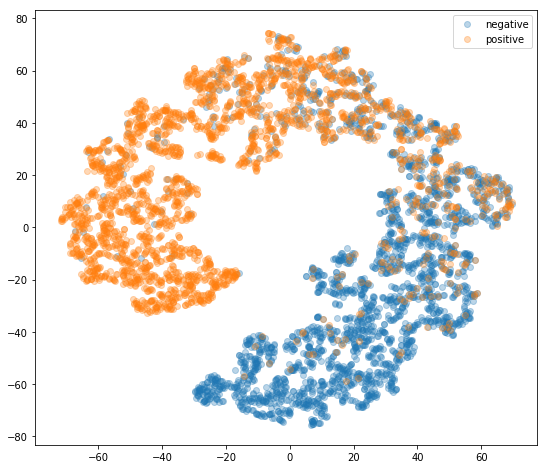

In [185]:
plt.show()

In [31]:
# 3. Evaluate the quality of document embedding to the subsequent classification task:
#    - with keras model.evaluate (from trained model)
#    - MLP classifier
#    - Linear model / SVM classifier ()
#    your task is not optimizing classifier or finetuning it -  so, use the most minimal parameter setting of classifier
#    Discuss the results.


# 3. a. keras model.evaluate


scores = model.evaluate(X_valid_pad[5000:10000], y_valid[5000:10000], verbose=0)

In [32]:
print("error loss: %s" %scores[0])

error loss: 0.450949940014


In [33]:
print("accuracy: %s" %scores[1])

accuracy: 0.8058


In [34]:
# 3. b. MLP classifier

#   (1 input layer - dimension is same with document embedding, 
#    1 dense layer - dimension is same with document embedding, 
#    1 prediction layer)
 
embedding_dim = doc_embedding_1_10000.shape[1]
hidden_size = 100

latent_vector = Input(shape=(embedding_dim,), name='latent_vector')
dense_layer = Dense(hidden_size, activation='linear', name='dense_layer')(latent_vector)
prediction = Dense(1, activation='sigmoid', name='prediction')(dense_layer)

mlp_model = Model(latent_vector, prediction)
mlp_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(mlp_model.summary())


mlp_model.fit(doc_embedding_1_10000[:5000], y_valid[:5000], batch_size=64, epochs=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_vector (InputLayer)   (None, 100)               0         
_________________________________________________________________
dense_layer (Dense)          (None, 100)               10100     
_________________________________________________________________
prediction (Dense)           (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
5000/5000 [==============================] - 2s 433us/step - loss: 0.3225 - acc: 0.8650
Epoch 2/3
5000/5000 [==============================] - 0s 97us/step - loss: 0.3015 - acc: 0.8742
Epoch 3/3
5000/5000 [==============================] - 1s 104us/step - loss: 0.3003 - acc: 0.8730


In [35]:
mlp_score = mlp_model.evaluate(doc_embedding_1_10000[5000:10000], y_valid[5000:10000], verbose=0)

In [36]:
print("error loss: %s" %mlp_score[0])

error loss: 0.31221791091


In [37]:
print("accuracy: %s" %mlp_score[1])

accuracy: 0.871


In [39]:
# 3. c. SVM classifier 

from sklearn.svm import LinearSVC
svm_model = LinearSVC(random_state=0)
svm_model.fit(doc_embedding_1_10000[:5000], y_valid[:5000])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [40]:
svm_score = svm_model.score(doc_embedding_1_10000[5000:10000], y_valid[5000:10000])

In [41]:
# accuracy of linear model
svm_score

0.871

### 8. Document similarity task from new unseen documents

In [ ]:
# YOUR CODE HERE
# (4 POINTS)

# 1. Generate document embedding from the trained model and new unseen document (preprocessed unlabelled data)
# 2. Sample 10 unseen unlabelled document embedding and compute document similarity with the previous 
#    resulting labelled embedding
# 3. Visualize the result of additional 10 new unseen documents and evaluate similarity results. 


In [43]:
# (My version)

# 1. Generate document embedding
# 1 POINT

max_review_length = 500
X_test_pad = sequence.pad_sequences(X_test[:10], maxlen=max_review_length)

query_embeddings = lstm_encoder_model_1.predict(X_test_pad)
savePickle(query_embeddings, os.path.join(EMBEDDING_PATH,'query_embeddings'))

In [46]:
# 2. Sample 10 unseen unlabelled document embedding and compute document similarity with the previous 
#    resulting labelled embedding
# 

# 2 POINTS

# simple approach ::

# - compute pairwise similarity between query embedding (10 unlabelled doc.embedding) 
#    and the references (5000 labelled document embeddings)

# - define threshold for document similarity measurement (e.g if cosine similarity > 0.7)

# - calculate class membership based on similarity value


from sklearn.metrics.pairwise import cosine_similarity

# treat 10 unlabelled document embedding as query document versus 5000 source references (labelled) document embeddings

def create_cosine_matrix(query_embeddings, source_embeddings):
    
    n_query = len(query_embeddings)
    n_source = len(source_embeddings)
    cosine_matrix = []
    # sim_ matrix : if cosine > 0.7: 1, 0 otherwise
    sim_matrix = []
    
    for i in range(n_query):
        
        query = query_embeddings[i: i+1]     
        sources = np.concatenate((query, source_embeddings), axis=0)   
        cosine_vals = cosine_similarity(query, sources)[0]
        cosine_matrix.append(cosine_vals)
        sim_vals = [1. if (val > 0.7) else 0. for val in cosine_vals]
        sim_matrix.append(sim_vals)
        
    return np.array(cosine_matrix), np.array(sim_matrix)


cosine_matrix, sim_matrix = create_cosine_matrix(query_embeddings, doc_embedding_1_10000[:5000])


In [54]:
cosine_matrix[0][:15]

array([ 0.99999988, -0.39376819,  0.98607624,  0.9665038 , -0.43823975,
       -0.54632676,  0.8563838 ,  0.9664073 ,  0.95984584,  0.94552851,
       -0.24028331,  0.99414426,  0.85533965,  0.90156806,  0.86949909], dtype=float32)

In [49]:
sim_matrix[0][:15]

array([ 1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.])

In [55]:
class_members = []
for i, sim_vector in enumerate(sim_matrix):
    vector = sim_vector[1:]
    class_member = []
    for j, val in enumerate(vector):
        if val == 1.:
            class_member.append(y_valid[j])
    class_members.append(class_member)    

In [59]:
query_membership = []
for members in class_members:
    arr_members = np.array(members)
    unique, counts = np.unique(arr_members, return_counts=True)
    query_membership.append(dict(zip(unique, counts)))

In [60]:
query_membership

[{0: 2210, 1: 389},
 {0: 1996, 1: 302},
 {0: 2215, 1: 391},
 {0: 2209, 1: 389},
 {0: 2199, 1: 385},
 {0: 2209, 1: 390},
 {0: 2210, 1: 388},
 {0: 2206, 1: 390},
 {0: 92, 1: 1756},
 {0: 2211, 1: 390}]

In [69]:
query_df = pd.read_csv(os.path.join(DATA_PATH,"unlabeledTrainData.tsv"), header=0, delimiter="\t", \
                        error_bad_lines=False, nrows=10)

for k in range(len(query_df)):
    print("query %s: %s \n" %(k, query_df.review[k]))

query 0: Watching Time Chasers, it obvious that it was made by a bunch of friends. Maybe they were sitting around one day in film school and said, \Hey, let's pool our money together and make a really bad movie!\" Or something like that. What ever they said, they still ended up making a really bad movie--dull story, bad script, lame acting, poor cinematography, bottom of the barrel stock music, etc. All corners were cut, except the one that would have prevented this film's release. Life's like that." 

query 1: I saw this film about 20 years ago and remember it as being particularly nasty. I believe it is based on a true incident: a young man breaks into a nurses' home and rapes, tortures and kills various women.<br /><br />It is in black and white but saves the colour for one shocking shot.<br /><br />At the end the film seems to be trying to make some political statement but it just comes across as confused and obscene.<br /><br />Avoid. 

query 2: Minor Spoilers<br /><br />In New Yo

In [82]:
# assign labels 
new_labels = []
for k in range(len(query_membership)):
    label = np.argmax(list(query_membership[k].values()))
    new_labels.append(label)

In [83]:
new_labels

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [104]:
embeddings = np.concatenate((query_embeddings, doc_embedding_1_10000[:5000]),axis=0)

In [106]:
(embeddings).shape

(5010, 100)

In [107]:
query_tsne_2dim = reduceDimensionTSNE(2,'random', embeddings)

In [108]:
savePickle(query_tsne_2dim, os.path.join(EMBEDDING_PATH,'concat_tsne_2dim'))

In [163]:
# 3. Visualize the result of additional 10 new unseen documents and evaluate similarity results.

# 1 POINT



x_q = (np.array(query_tsne_2dim))[:10,0]
y_q = (np.array(query_tsne_2dim))[:10,1]
labeled_query = list(zip(new_labels,x_q,y_q))

x = (np.array(query_tsne_2dim))[10:,0]
y = (np.array(query_tsne_2dim))[10:,1]
labels = y_valid[:5000]
labeled_source = list(zip(labels,x,y))


df_query_embedding = pd.DataFrame(labeled_query, columns=['sentiment_labels', 'vector_0', 'vector_1'])
sorted_df_query = df_query_embedding.sort_values(['sentiment_labels'], ascending=True)
sorted_df_query = sorted_df_query.reset_index(drop=True)

df_source_embedding = pd.DataFrame(labeled_source, columns=['sentiment_labels', 'vector_0', 'vector_1'])
sorted_df_source = df_source_embedding.sort_values(['sentiment_labels'], ascending=True)
sorted_df_source = sorted_df_source.reset_index(drop=True)

class_labels_q = sorted_df_source.sentiment_labels.unique()
nlabels_q = len(class_labels_q)
colors_q = class_labels_q

plt.clf()
plt.rcParams["figure.figsize"] = (12,5)

for i in range(nlabels_q):
    class_label = class_labels_q[i]
    color = colors_q[i]
    
    u0 = sorted_df_source[sorted_df_source['sentiment_labels'] == class_label]['vector_0']
    u1 = sorted_df_source[sorted_df_source['sentiment_labels'] == class_label]['vector_1']    
    plt.scatter(u0, u1, label=color, alpha=0.3)
    
    v0 = sorted_df_query[sorted_df_query['sentiment_labels'] == class_label]['vector_0']
    v1 = sorted_df_query[sorted_df_query['sentiment_labels'] == class_label]['vector_1']    
    plt.scatter(v0, v1, label=color, marker='+')
   
plt.legend(['negative-source', 'negative-query', 'positive-source', 'positive-query'], loc='upper right')
#plt.savefig('docvec_val_data_5000_query10.png', dpi=100)

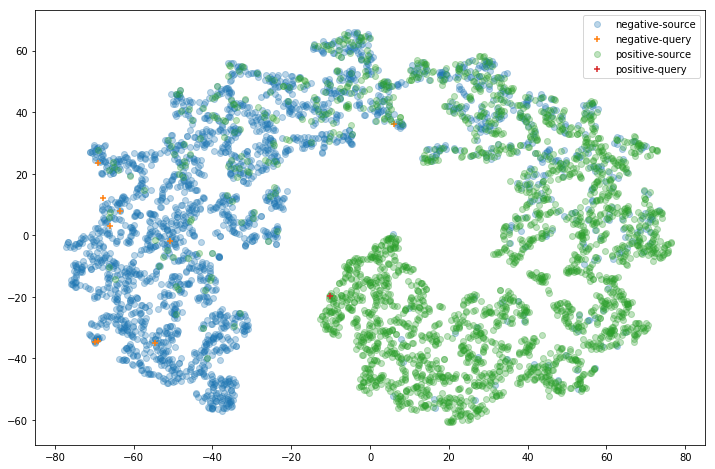

In [164]:
plt.show()